Epoch 1/300
1563/1563 [==============================] - 34s 19ms/step - loss: 3.7560 - accuracy: 0.1342 - val_loss: 3.3075 - val_accuracy: 0.2026 - lr: 5.0000e-04
Epoch 2/300
1563/1563 [==============================] - 30s 19ms/step - loss: 3.0759 - accuracy: 0.2427 - val_loss: 3.0675 - val_accuracy: 0.2590 - lr: 5.0000e-04
Epoch 3/300
1563/1563 [==============================] - 30s 19ms/step - loss: 2.6722 - accuracy: 0.3211 - val_loss: 2.3761 - val_accuracy: 0.3871 - lr: 5.0000e-04
Epoch 4/300
1563/1563 [==============================] - 30s 19ms/step - loss: 2.4115 - accuracy: 0.3749 - val_loss: 2.2346 - val_accuracy: 0.4142 - lr: 5.0000e-04
Epoch 5/300
1563/1563 [==============================] - 30s 19ms/step - loss: 2.2231 - accuracy: 0.4162 - val_loss: 2.1766 - val_accuracy: 0.4332 - lr: 5.0000e-04
Epoch 6/300
1563/1563 [==============================] - 30s 19ms/step - loss: 2.0971 - accuracy: 0.4422 - val_loss: 1.7768 - val_accuracy: 0.5153 - lr: 5.0000e-04
Epoch 7/300
1563

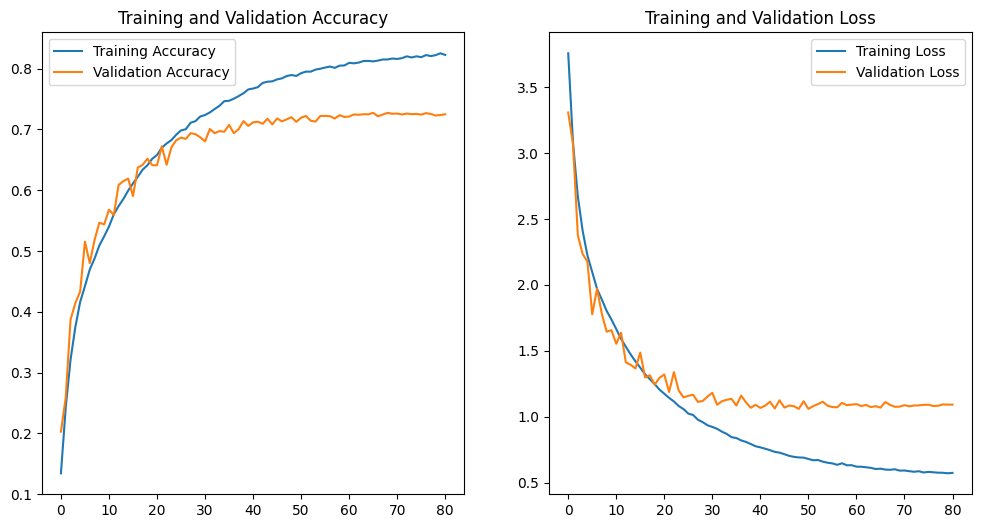

313/313 [==============================] - 1s 2ms/step


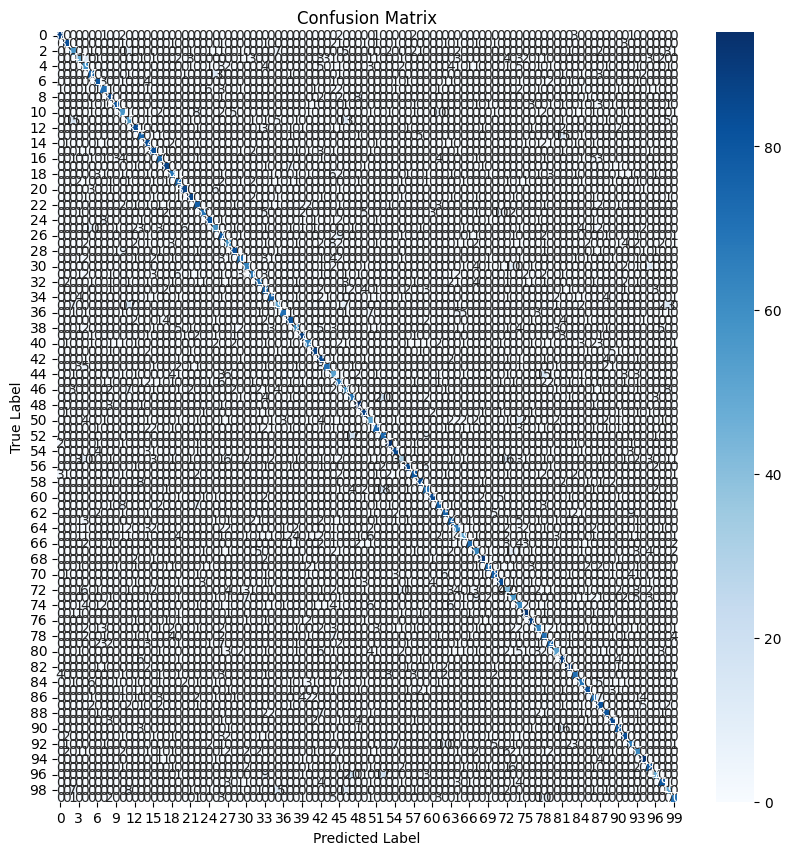

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import confusion_matrix

# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)
datagen.fit(x_train)

# Custom learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return 0.0005
    else:
        return lr * tf.math.exp(-0.05)

# Model architecture with adjusted dropout rates
model = Sequential([
    Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Dense(100, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=40, min_lr=0.00001)

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=300,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, lr_scheduler]
)

# Evaluate the model
model.load_weights('best_model.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Make predictions and compute the confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()